## Training the model and define the threshold 

### Import libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
import warnings
import re
from sklearn.model_selection import (train_test_split, GridSearchCV)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [23]:
def main_inf(df):
    print("DataFrame shape: ", df.shape)
    print("Nan rate: ", df.isna().mean().mean())
    print("Doublons: ", df.duplicated().sum())  

### Import main dataset

In [24]:
df =pd.read_csv('cleaned.csv').drop(columns='Unnamed: 0')
main_inf(df)
categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
df=df.drop(columns=categorical_columns)
df=df.dropna()

DataFrame shape:  (307507, 171)
Nan rate:  0.07917560456047813
Doublons:  0


In [25]:
df.shape

(35185, 161)

In [26]:
df.head()

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
13,0.0,0.0,1.0,1.0,1.0,225000.0,918468.0,28966.5,697500.0,0.016612,...,13508.920500,405267.615,11783.520,16967.295,13508.920500,405267.615,-21.0,-962.533333,-28876.0,30.0
22,0.0,1.0,0.0,1.0,1.0,450000.0,497520.0,32521.5,450000.0,0.020713,...,119294.595000,954356.760,23531.175,770004.315,119294.595000,954356.760,-425.0,-1105.875000,-8847.0,8.0
25,0.0,1.0,0.0,0.0,0.0,90000.0,225000.0,11074.5,225000.0,0.028663,...,11820.645000,70923.870,9035.685,17846.145,11820.645000,70923.870,-233.0,-730.666667,-4384.0,6.0
32,0.0,1.0,0.0,1.0,0.0,90000.0,199008.0,20893.5,180000.0,0.010032,...,19217.569091,422786.520,5305.995,35172.135,19217.569091,422786.520,-235.0,-1247.409091,-27443.0,22.0
35,0.0,1.0,0.0,1.0,0.0,112500.0,450000.0,44509.5,450000.0,0.008575,...,6089.499000,121789.980,130.365,7297.515,5359.290750,107185.815,-1101.0,-1722.700000,-34454.0,20.0


### Train LGBM Classifier 

In [27]:
import imblearn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, f1_score
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier

# load your data into X and y

y = df['TARGET']
X = df.drop(columns=['TARGET'])


X_resampled = X
y_resampled = y

# define the LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'roc_auc',
    'colsample_bytree': 0.4069597159452327,
     'learning_rate': 0.057736760620294536,
     'max_depth': 11, 
     'min_child_samples': 11,
     'n_estimators': 153,
     'num_leaves': 99,
     'reg_alpha': 9.822683433294355, 
     'reg_lambda': 5.167358912710143,
     'subsample': 0.3347462573473681,
    'random_state': 42
}

# implement k-fold stratification
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# create an empty list to hold the classification reports for each fold
classification_reports = []

# loop over the folds
for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X_resampled, y_resampled)):
    print(f"Fold {fold_idx+1}/{n_splits}")

    # extract the train and test data for this fold
    X_train, y_train = X_resampled.iloc[train_idx], y_resampled.iloc[train_idx]
    X_test, y_test = X_resampled.iloc[test_idx], y_resampled.iloc[test_idx]

    # create an LGBMClassifier instance
    clf = LGBMClassifier(**params)

    # fit the classifier to the training data
    clf.fit(X_train, y_train)

    # predict on the test set
    y_pred = clf.predict(X_test)

    # evaluate the performance of the model
    classification_reports.append(classification_report(y_test, y_pred))

# print the average classification report across all folds
print(f"Average classification report across {n_splits} folds:\n{pd.DataFrame(classification_reports).apply(pd.Series.value_counts).sum(axis=1) / n_splits}")
#cl_rep=pd.DataFrame(classification_reports)#.apply(pd.Series.value_counts).sum(axis=1) 


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Average classification report across 5 folds:
              precision    recall  f1-score   support\n\n         0.0       0.93      1.00      0.96      6528\n         1.0       0.52      0.02      0.05       509\n\n    accuracy                           0.93      7037\n   macro avg       0.73      0.51      0.50      7037\nweighted avg       0.90      0.93      0.90      7037\n    0.2
              precision    recall  f1-score   support\n\n         0.0       0.93      1.00      0.96      6528\n         1.0       0.56      0.02      0.03       509\n\n    accuracy                           0.93      7037\n   macro avg       0.75      0.51      0.50      7037\nweighted avg       0.90      0.93      0.90      7037\n    0.2
              precision    recall  f1-score   support\n\n         0.0       0.93      1.00      0.96      6528\n         1.0       0.73      0.02      0.03       509\n\n    accuracy                           0.93      7037\n 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96      6528
         1.0       0.52      0.02      0.05       509

    accuracy                           0.93      7037
   macro avg       0.73      0.51      0.50      7037
weighted avg       0.90      0.93      0.90      7037

Report Lines:
['              precision    recall  f1-score   support', '', '         0.0       0.93      1.00      0.96      6528', '         1.0       0.52      0.02      0.05       509', '', '    accuracy                           0.93      7037', '   macro avg       0.73      0.51      0.50      7037', 'weighted avg       0.90      0.93      0.90      7037', '']
Scores:
['weighted', 'avg', '0.90', '0.93', '0.90', '7037']
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96      6528
         1.0       0.56      0.02      0.03       509

    accuracy                      

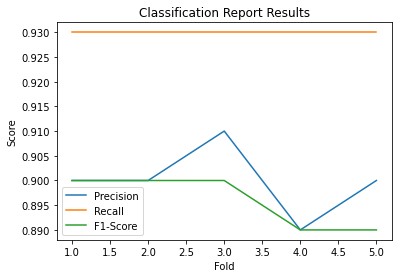

In [28]:
# Extract the precision, recall, and F1-score from the classification_reports
precision = []
recall = []
f1_score = []

for report in classification_reports:
    print("Classification Report:")
    print(report)
    lines = report.split('\n')
    print("Report Lines:")
    print(lines)
    if len(lines) > 0 and len(lines[0]) > 0:
        scores = lines[-2].split()
        print("Scores:")
        print(scores)
        if len(scores) >= 4:
            precision.append(float(scores[2]))
            recall.append(float(scores[3]))
            f1_score.append(float(scores[4]))

# Plot the results
plt.plot(range(1, n_splits+1), precision, label='Precision')
plt.plot(range(1, n_splits+1), recall, label='Recall')
plt.plot(range(1, n_splits+1), f1_score, label='F1-Score')

plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Classification Report Results')
plt.legend()
plt.show()

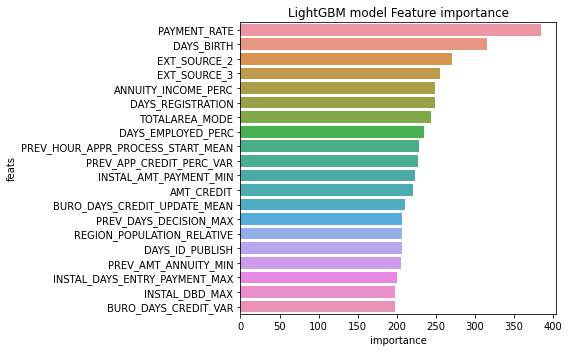

In [29]:
cols=df.columns.tolist()
del cols[0:1]
feat_imp=pd.DataFrame()
feat_imp['feats']=cols
feat_imp['importance']=clf.feature_importances_.astype('int').tolist()
feat_imp.to_csv('feat_imp.csv')
plt.figure(figsize=(8, 5))
sns.barplot(x='importance',y='feats', data=feat_imp.sort_values(by='importance', ascending=False)[0:20])
plt.title('LightGBM model Feature importance')
plt.tight_layout()
plt.savefig('lgbm_importances01.png')

In [30]:
y_pred=clf.predict_proba(X_train)
y_pred[:,0]

array([0.97775654, 0.98929708, 0.98144713, ..., 0.961537  , 0.9818504 ,
       0.95224775])

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

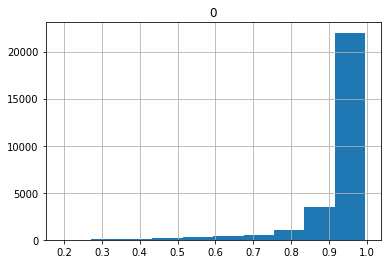

In [31]:
pd.DataFrame(y_pred[:,0]).hist()

### Default threshold 0.5 examining

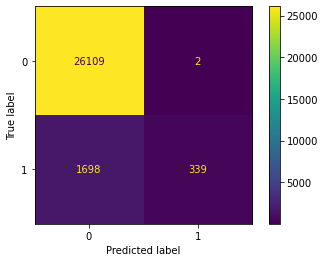

In [32]:
threshold_default=0.5
thrs_def=pd.DataFrame(y_pred[:,0])[0].apply(lambda x : 0 if(x >= threshold_default) else 1)
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_train,thrs_def)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

### Moving threshold and 'Cout metier' function

In [33]:
def crs():
    thrs=[]
    idx=[]
    cout_total=[]
   
    for i in range(1,99):
        d=pd.DataFrame(y_pred[:,0])[0].apply(lambda x : 0 if(x >= i/100) else 1)
        idx.append(i)
        thrs.append(i/100)
        #F1_score = metrics.f1_score(dfX.TARGET, d)
        #f1.append(F1_score)
        cout_total.append(cout_metier(y_train.values, d.values, 10,1))

        
    return [idx,cout_total,thrs]


In [34]:
def cout_metier(y, y_d, poids_FN, poids_FP):
    sum_=0
    for n in range(len(y)):
        if y[n]==0:
            if y[n]==y_d[n]:
                pass
            else:
                sum_=sum_+poids_FP
        else:
            if y[n]==y_d[n]:
                pass
            else:
                sum_=sum_+poids_FN
            
            
    return sum_       
        

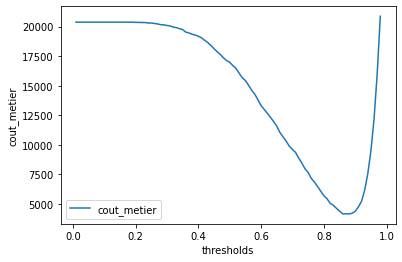

In [35]:
idx, cout_total,thrs=crs()
plt.plot(thrs,cout_total,label='cout_metier')
plt.xlabel('thresholds')
plt.ylabel('cout_metier')
plt.legend()

Optimized threshold found:  0.88


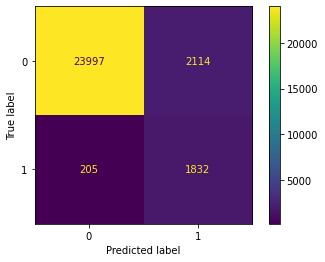

In [36]:
ixc=np.argmin(cout_total)
print('Optimized threshold found: ',thrs[ixc])
thrs_opt=thrs[ixc]
thrsh_opt=pd.DataFrame(y_pred[:,0])[0].apply(lambda x : 0 if(x >= thrs_opt) else 1)
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_train,thrsh_opt)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

In [37]:
# Step 3: Calculate the correlation matrix
correlation_matrix_t = df.corr()['TARGET']

In [38]:
cm=correlation_matrix_t.sort_values(ascending=False)[0:10]

In [39]:
cmi=cm.index

In [40]:
correlation_matrix=df[cmi].corr()

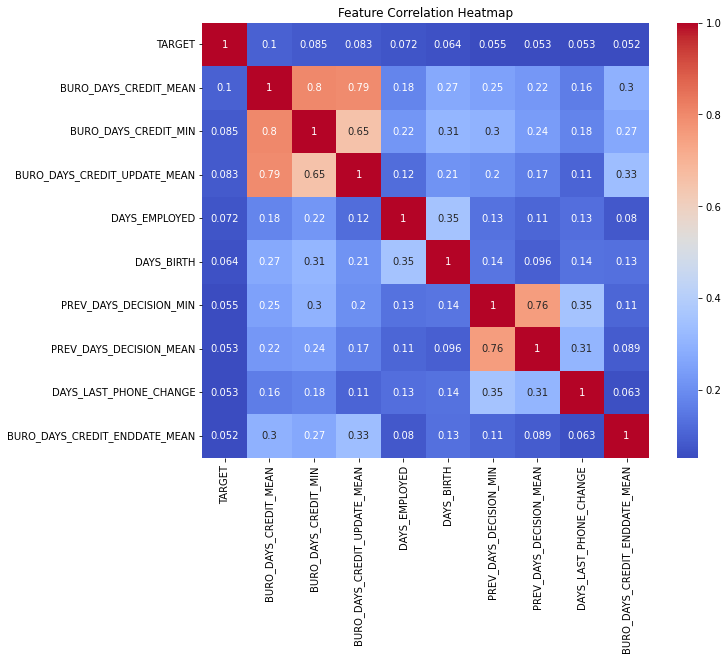

In [41]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()
